### Imports

In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import statsmodels
from statsmodels.formula.api import ols

import sqlite3 
import json
import folium 
import folium.plugins as plugins
import branca.colormap as cm

%matplotlib inline

import pickle




### Functions

In [75]:
def clean_df(df, 
            bedrooms_min=0, 
            bedrooms_max=100, 
            condition_min = 0, 
            condition_max = 10, 
            grade_min = 0, 
            grade_max = 20, 
            house_age_min = 0, 
            house_age_max = 300, 
            price_min = 0, 
            price_max = 7700000):
    """
    Cleans the dataframe with specified conditions.

    df - dataframe that will be altered
    bedrooms_min - Minimum bedrooms, set to 3 as default
    bedrooms_max - Maximum bedrooms, set to 4 as default
    condition_min - Minimum condition of a home, set to 1 (Fair) by default
    condition_max - Maximum condition of a home, set to 4 (Very Good) by default
    grade_min - Minimum grade for a home, set to 5 (Fair) by default
    grade_max - Maximum grade for a home, set to 11 (Excellent) by default
    house_age_min - Minimum age for a home, set to 0 by default
    house_age_max - Maximum age for a home, set to 300 by default 
    price_min - Minimum price for a home, set to 0 by default 
    price_max - Maximum price for a home, set to 7700000 by default
    
    """

    # Creating a copy of df and creating for future data shaping.
    df_copy = df.copy()
    #drop_columns = ['waterfront', 'view', 'sqft_above', 'sqft_basement','sqft_lot','sqft_living15','sqft_lot15']
    condition_dict = {'Poor':0, 'Fair':1, 'Average':2, 'Good':3, 'Very Good':4}

    # Dropping unnecessary columns and removing a 
   # df_copy.drop(drop_columns, axis= 1, inplace=True)
    df_copy = df_copy[df_copy['bedrooms']!=33]
    
    df_copy['date'] = pd.to_datetime(df_copy["date"])
    
    df_copy['grade_value'] = df_copy['grade'].map(lambda x: x[:2])
    df_copy['grade_value'] = df_copy['grade_value'].astype(int)

    df_copy['age'] = df_copy['yr_built']
    df_copy.loc[df_copy['yr_renovated'] != 0, 'age'] = df_copy['yr_renovated']
    df_copy['age'] = df_copy['age'].map(lambda x: 2015-x)

    df_copy['condition_num'] = df_copy['condition'].map(condition_dict)

    df_copy = df_copy[df_copy['bedrooms'] >= bedrooms_min]
    df_copy = df_copy[df_copy['bedrooms'] <= bedrooms_max]

    df_copy = df_copy[df_copy['condition_num'] >= condition_min]
    df_copy = df_copy[df_copy['condition_num'] <= condition_max]

    df_copy = df_copy[df_copy['grade_value'] >= grade_min]
    df_copy = df_copy[df_copy['grade_value'] <= grade_max]

    df_copy = df_copy[df_copy['age'] >= house_age_min]
    df_copy = df_copy[df_copy['age'] <= house_age_max]

    df_copy = df_copy[df_copy['price'] >= price_min]
    df_copy = df_copy[df_copy['price'] <= price_max]

    df_clean = df_copy.copy()

    return(df_clean)

def map_feature_by_zipcode(zipcode_data, col):
    """
    Generates a folium map of Seattle
    :param zipcode_data: zipcode dataset
    :param col: feature to display
    :return: m
    """

    # read updated geo data
    king_geo = "cleaned_geodata.json"

    # Initialize Folium Map with Seattle latitude and longitude
    m = folium.Map(location=[47.35, -121.9], zoom_start=9.25,
                   detect_retina=True, control_scale=False, tiles='OpenStreetMap')

    # Create choropleth map
    m.choropleth(
        geo_data=king_geo,
        name='choropleth',
        data=zipcode_data,
        # col: feature of interest
        columns=['zipcode', col],
        key_on='feature.properties.ZIPCODE',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='house ' + col
    )
    folium.LayerControl().add_to(m)

    # Save map based on feature of interest
    m.save(col + '.html')

    return m

### Code

In [80]:
df = pd.read_csv('./data/kc_house_data.csv')

In [81]:
df = clean_df(df)

In [82]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'grade_value', 'age',
       'condition_num'],
      dtype='object')

In [97]:
variables = [ 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'sqft_above', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'grade_value', 'age',
       'condition_num']
price_var = ['price'] + variables


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17754 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             17754 non-null  int64         
 1   date           17754 non-null  datetime64[ns]
 2   price          17754 non-null  float64       
 3   bedrooms       17754 non-null  int64         
 4   bathrooms      17754 non-null  float64       
 5   sqft_living    17754 non-null  int64         
 6   sqft_lot       17754 non-null  int64         
 7   floors         17754 non-null  float64       
 8   waterfront     15808 non-null  object        
 9   view           17703 non-null  object        
 10  condition      17754 non-null  object        
 11  grade          17754 non-null  object        
 12  sqft_above     17754 non-null  int64         
 13  sqft_basement  17754 non-null  object        
 14  yr_built       17754 non-null  int64         
 15  yr_renovated   1775

In [46]:
df_copy = df[price_var]

In [47]:
q1 = df_copy.quantile(0.25)
q3 = df_copy.quantile(0.75)
iqr = q3 - q1

In [48]:
iqr

price            316000.00
sqft_living        1100.00
grade_value           1.00
condition_num         1.00
bedrooms              1.00
bathrooms             0.75
age                  44.00
floors                1.00
dtype: float64

In [70]:
df_find = df_copy[(df_copy < (q1 - 1.5 * iqr)) | (df_copy > (q3 + 1.5 * iqr))]

In [71]:
df_find['check'] = df_find['price'] * df_find['sqft_living']

In [72]:
df_find['check'].value_counts()

8.114400e+09    2
6.580000e+09    2
1.448400e+10    1
5.990200e+09    1
1.036020e+10    1
               ..
7.681200e+09    1
6.874700e+09    1
5.532000e+09    1
9.990000e+09    1
7.249500e+09    1
Name: check, Length: 274, dtype: int64

In [68]:
df_find[df_find['check'] != np.nan]

,price,sqft_living,grade_value,condition_num,bedrooms,bathrooms,age,floors,check
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
21592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df['price'].sort_values()

8267       82000.0
2139       82500.0
18453      83000.0
3763       84000.0
10242      85000.0
           ...    
21560    3570000.0
2862     3600000.0
15241    3640000.0
6502     3650000.0
2083     3850000.0
Name: price, Length: 17439, dtype: float64

In [98]:
y = df['price']
x = df[variables]
X = sm.add_constant(x)
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     2317.
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:43:46   Log-Likelihood:            -2.4442e+05
No. Observations:               17754   AIC:                         4.889e+05
Df Residuals:                   17741   BIC:                         4.890e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.993e+06    7.3e+05      4.100      0.000    1.56e+06    4.42e+06
bathrooms      3.578e+04   4050.066      8.833      0.000    2.78e+04    4.37e+04
sqft_living     167.5793      5.216     32.125      0.000     157.355     177.804
sqft_lot          0.0100      0.059      0.168      0.867      -0.106       0.126
floors         3.346e+04   4469.577      7.487      0.000    2.47e+04    4.22e+04
sqft_above      -24.5947      5.243     -4.691      0.000     -34.872     -14.317
yr_built      -2066.5444    362.260     -5.705      0.000   -2776.609   -1356.480
yr_renovated     78.2817     11.122      7.039      0.000      56.482     100.081
sqft_living15    32.3932      4.221      7.674      0.000      24.119      40.668
sqft_lot15       -0.3862      0.091     -4.247      0.000      -0.564      -0.208
grade_value    1.316e+05   2633.324     49.969      0.000    1.26e+05    1.37e+05
age            1803.5942    367.806      4.904      0.000    1082.658    2524.531
condition_num  1.707e+04   2943.361      5.798      0.000    1.13e+04    2.28e+04
==============================================================================
Omnibus:                    15530.167   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1458595.572
Skew:                           3.767   Prob(JB):                         0.00
Kurtosis:                      46.760   Cond. No.                     2.17e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
my_sample = df.sample(1)
my_sample_price = my_sample.iloc[0,2]
my_sample_pt = my_sample[variables]

# Show my random sample off
print(f'Price of sample: ${my_sample_price}')
my_sample_pt

Price of sample: $795127.0


,sqft_living,grade_value,condition_num,bedrooms,bathrooms,age,floors
12307,4360,10,2,4,3.25,22.0,1.0


In [48]:
def train_lr_randomly(data, sample_pt=None, ntimes=100):
    '''
    Takes in features & targets from `data` to train a linear regression with a
    random sample `ntimes`. It then returns a list of R2 scores, RMSEs, and the 
    predictions from a provided data point of features `sample_pt`.
    '''
    # To save all of our predictions
    r2 = []
    rmse = []
    # Only return predictions if there is something to predict (sample_pt given)
    point_preds = [] if (sample_pt is not None) else None

    # We'll repeat this little experiment to see how the model does
    for i in range(ntimes):
        # Creating a random sample of data to train on
        df_sample = data.sample(5000, replace=True)
        y = df_sample.price
        X = df_sample.drop('price', axis=1)

        # Our linear regression model about to be trained
        lr = LinearRegression()
        lr.fit(X, y)

        # Making predictions & evaluating on the data we used to train the model
        y_hat = lr.predict(X)
        rmse.append(np.sqrt(mean_squared_error(y, y_hat)))
        r2.append(lr.score(X, y))

        # Making a prediction on the one point the model definitely never saw
        if sample_pt is not None:
            y_hat_pt = lr.predict(sample_pt)
            # Getting just the single point to add into list
            point_preds.append(y_hat_pt[0])
    
    return r2, rmse, point_preds

In [49]:
r2_simple, rmse_simple, pt_preds_simple = train_lr_randomly(
                                                        data=df[price_var], 
                                                        sample_pt=my_sample_pt,
                                                        ntimes=100                            
)

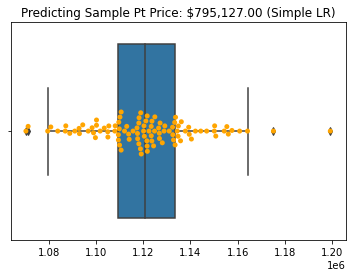

In [50]:
ax = sns.boxplot(x=pt_preds_simple);
ax = sns.swarmplot(x=pt_preds_simple, color='orange', ax=ax)
ax.set_title(f'Predicting Sample Pt Price: ${my_sample_price:,.2f} (Simple LR)');

In [51]:
df_pol = df[variables]

In [52]:
pf = PolynomialFeatures(2)

df_poly = pd.DataFrame(pf.fit_transform(df_pol))
df_poly.index = df_pol.index
df_poly['price'] = df['price']

cols = list(df_poly)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('price')))

df_poly = df_poly.loc[:, cols]

df_poly.head(10)

,price,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,221900.0,1.0,1180.0,7.0,2.0,3.0,1.00,60.0,1.0,1392400.0,...,9.0,3.00,180.0,3.0,1.0000,60.0,1.0,3600.0,60.0,1.0
1,538000.0,1.0,2570.0,7.0,2.0,3.0,2.25,24.0,2.0,6604900.0,...,9.0,6.75,72.0,6.0,5.0625,54.0,4.5,576.0,48.0,4.0
3,604000.0,1.0,1960.0,7.0,4.0,4.0,3.00,50.0,1.0,3841600.0,...,16.0,12.00,200.0,4.0,9.0000,150.0,3.0,2500.0,50.0,1.0
4,510000.0,1.0,1680.0,8.0,2.0,3.0,2.00,28.0,1.0,2822400.0,...,9.0,6.00,84.0,3.0,4.0000,56.0,2.0,784.0,28.0,1.0
5,1230000.0,1.0,5420.0,11.0,2.0,4.0,4.50,14.0,1.0,29376400.0,...,16.0,18.00,56.0,4.0,20.2500,63.0,4.5,196.0,14.0,1.0
6,257500.0,1.0,1715.0,7.0,2.0,3.0,2.25,20.0,2.0,2941225.0,...,9.0,6.75,60.0,6.0,5.0625,45.0,4.5,400.0,40.0,4.0
7,291850.0,1.0,1060.0,7.0,2.0,3.0,1.50,52.0,1.0,1123600.0,...,9.0,4.50,156.0,3.0,2.2500,78.0,1.5,2704.0,52.0,1.0
8,229500.0,1.0,1780.0,7.0,2.0,3.0,1.00,55.0,1.0,3168400.0,...,9.0,3.00,165.0,3.0,1.0000,55.0,1.0,3025.0,55.0,1.0
9,323000.0,1.0,1890.0,7.0,2.0,3.0,2.50,12.0,2.0,3572100.0,...,9.0,7.50,36.0,6.0,6.2500,30.0,5.0,144.0,24.0,4.0
10,662500.0,1.0,3560.0,8.0,2.0,3.0,2.50,50.0,1.0,12673600.0,...,9.0,7.50,150.0,3.0,6.2500,125.0,2.5,2500.0,50.0,1.0


In [53]:
# Let's make sure we have another sample point to test our models
my_sample_pt_poly = pf.transform(my_sample_pt)

# Show my random sample off
print(f'Price of sample: ${my_sample_price}')
my_sample_pt_poly.shape

Price of sample: $795127.0


(1, 36)

In [54]:
# Run 100 linear regression trainings on some random polynomial features data
# from df_poly and compare it with the random sample point
r2_poly, rmse_poly, pt_preds_poly = train_lr_randomly(
                                                data=df_poly, 
                                                sample_pt=my_sample_pt_poly,
                                                ntimes=100 
)

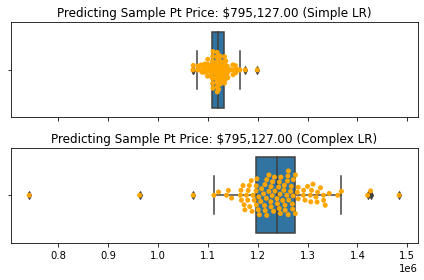

In [55]:
f, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,4));

# Simple model
ax = sns.boxplot(x=pt_preds_simple, ax=ax1);
ax = sns.swarmplot(x=pt_preds_simple, color='orange', ax=ax)
ax.set_title(f'Predicting Sample Pt Price: ${my_sample_price:,.2f} (Simple LR)');

# Complex model
ax = sns.boxplot(x=pt_preds_poly, ax=ax2);
ax = sns.swarmplot(x=pt_preds_poly, color='orange', ax=ax)
ax.set_title(f'Predicting Sample Pt Price: ${my_sample_price:,.2f} (Complex LR)');

# Makes spacing work better
f.tight_layout()

In [56]:
print('How it did on its own training data:')
print(f'\t- simple mean {np.mean(rmse_simple)}')
print(f'\t- complex mean {np.mean(rmse_poly)}')
print('\n')

print('How it did on data it never saw:')
print(f'\t- simple variance {np.std(pt_preds_simple)}')
print(f'\t- complex variance {np.std(pt_preds_poly)}')

How it did on its own training data:
	- simple mean 206242.77243732128
	- complex mean 196660.34402148076


How it did on data it never saw:
	- simple variance 21866.403724966127
	- complex variance 86805.86049497583


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=None,
                                                    random_state=42)

In [58]:
display(X_train.head())
display(X_test.head())

,const,sqft_living,grade_value,condition_num,bedrooms,bathrooms,age,floors
2868,1.0,1720,8,3,3,1.75,41.0,1.0
6897,1.0,1660,7,2,3,1.00,105.0,1.5
165,1.0,1580,7,2,3,1.75,39.0,1.0
703,1.0,1400,7,2,4,2.00,115.0,1.0
17056,1.0,1270,7,3,3,1.75,25.0,1.0


,const,sqft_living,grade_value,condition_num,bedrooms,bathrooms,age,floors
21457,1.0,3560,10,2,4,2.75,1.0,2.0
2492,1.0,1510,7,1,3,1.75,36.0,1.0
7763,1.0,1780,8,2,3,2.25,8.0,3.0
17261,1.0,1290,7,2,3,1.75,31.0,1.0
3887,1.0,3410,10,3,4,2.75,53.0,1.5


In [59]:
print(X_train.shape)
print(X_test.shape)

print(X_train.shape[0] == y_train.shape[0])
print(X_test.shape[0] == y_test.shape[0])

(10259, 8)
(3420, 8)
True
True


In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [61]:
lr.predict(X_train)

array([512695.3765833 , 534848.53085167, 332680.23362871, ...,
       691415.05018326, 339868.11550229, 890582.84951685])

In [62]:
lr.score(X_train, y_train)

0.5624373182252487

In [63]:
rmse_total = (sum((y_test - lr.predict(X_test))**2)/len(y_test))**.5
rmse_total

201328.8911991788

In [64]:
lr.score(X_test, y_test)

0.5795527780437445

In [65]:
((y_test-lr.predict(X_test))**2).sort_values(ascending=False).cumsum()/sum(((y_test-lr.predict(X_test))**2).sort_values(ascending=False))

17137    0.020248
11245    0.040079
7425     0.056898
5444     0.072329
18314    0.086091
           ...   
19947    1.000000
19091    1.000000
1769     1.000000
17421    1.000000
12452    1.000000
Name: price, Length: 3420, dtype: float64

In [66]:
poly_2 = PolynomialFeatures(4)

X_poly = pd.DataFrame(
            poly_2.fit_transform(df_pol)
                      )

y = df.price
X_poly.head()

,0,1,2,3,4,5,6,7,8,9,...,320,321,322,323,324,325,326,327,328,329
0,1.0,1180.0,7.0,2.0,3.0,1.00,60.0,1.0,1392400.0,8260.0,...,1.00,216000.0,3600.0,60.0,1.0,12960000.0,216000.0,3600.0,60.0,1.0
1,1.0,2570.0,7.0,2.0,3.0,2.25,24.0,2.0,6604900.0,17990.0,...,20.25,31104.0,2592.0,216.0,18.0,331776.0,27648.0,2304.0,192.0,16.0
2,1.0,1960.0,7.0,4.0,4.0,3.00,50.0,1.0,3841600.0,13720.0,...,9.00,375000.0,7500.0,150.0,3.0,6250000.0,125000.0,2500.0,50.0,1.0
3,1.0,1680.0,8.0,2.0,3.0,2.00,28.0,1.0,2822400.0,13440.0,...,4.00,43904.0,1568.0,56.0,2.0,614656.0,21952.0,784.0,28.0,1.0
4,1.0,5420.0,11.0,2.0,4.0,4.50,14.0,1.0,29376400.0,59620.0,...,20.25,12348.0,882.0,63.0,4.5,38416.0,2744.0,196.0,14.0,1.0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y,
                                                    test_size=0.2,
                                                    random_state=42)
lr_poly = LinearRegression()

# Always fit on the training set
lr_poly.fit(X_train, y_train)

lr_poly.score(X_train, y_train)

0.6516009238697116

In [68]:
lr_poly.score(X_test, y_test)

0.6257585223061348

In [69]:
def price_calculator(data=df):
    sqft_living = int(input('How many SQFT is the house?'))
    grade_value = int(input('What grade is the house? From 4-Low to 13-Mansion'))
    bedrooms = int(input('How many bedrooms does the house have?'))
    bathrooms = float(input('How many bathrooms does the house have?'))
    floors = int(input('How many floors does the house have?'))
    condition_num = int(input('What condition is the house in? 1-Fair to 4-Very Good'))
    age = int(input('How many years passed after last renovation? If never renovated put age of the house. '))

    y = data['price']
    x = data[['sqft_living','grade_value','bedrooms','bathrooms','floors','condition_num','age']]
    X = sm.add_constant(x)
    model = sm.OLS(y,X).fit()
    coef = model.params
    price = coef['const'] + sqft_living*coef['sqft_living'] + grade_value*coef['grade_value'] + bedrooms*coef['bedrooms'] + bathrooms*coef['bathrooms'] + floors*coef['floors'] + condition_num*coef['condition_num'] + age*coef['age']
    price = round(round(price/1000)*1000)
    #print(f'For given specifications expected price range for a house would be USD {price-50000} - {price+50000}. ')
    return price-50000, price+50000

In [70]:
#price_calculator()

In [71]:
def price_calculator_partial(sqft_living,grade_value,bedrooms,bathrooms,floors,condition_num,age,data=df):
    y = data['price']
    x = data[['sqft_living','grade_value','bedrooms','bathrooms','floors','condition_num','age']]
    X = sm.add_constant(x)
    model = sm.OLS(y,X).fit()
    coef = model.params
    price = coef['const'] + sqft_living*coef['sqft_living'] + grade_value*coef['grade_value'] + bedrooms*coef['bedrooms'] + bathrooms*coef['bathrooms'] + floors*coef['floors'] + condition_num*coef['condition_num'] + age*coef['age']
    price = int(round(round(price/1000)*1000,2))
    #print(f'For given specifications expected price range for a house would be USD {price-50000} - {price+50000}. ')
    return price

In [72]:
#price_calculator_partial(2500,6,3,2,1,3,10,data=df)

In [73]:
def price_calculator_zipcode(zipcode, data=df):
    sqft_living = int(input('How many SQFT is the house?'))
    grade_value = int(input('What grade is the house? From 1-Fair to 7-Excellent'))+4
    bedrooms = int(input('How many bedrooms does the house have?'))
    bathrooms = float(input('How many bathrooms does the house have?'))
    floors = int(input('How many floors does the house have?'))
    condition_num = int(input('What condition is the house in? 1-Fair to 4-Very Good'))
    age = int(input('How many years passed after last renovation? If never renovated put age of the house. '))   

    data_zipcode = data[data['zipcode']==zipcode]
    price_area = price_calculator_partial(sqft_living,grade_value,bedrooms,bathrooms,floors,condition_num,age,data)
    price_zipcode = price_calculator_partial(sqft_living,grade_value,bedrooms,bathrooms,floors,condition_num,age,data_zipcode)
    if price_zipcode > (730000/1.1):
        print(f'This zipcode is too expensive for given specifications, expected price is {price_zipcode}')
    else:
        print(f'For given specifications expected price range for a house in {zipcode} zipcode would be  ${int(price_zipcode-price_zipcode*.1)} - {int(price_zipcode+price_zipcode*.1)}. ')
        print(f'For given specifications expected price range for a house in King County would be ${int(price_area-price_area*.1)} - {int(price_area+price_area*.1)}. ')
        if price_area < price_zipcode:
            print(f'This zipcode is overpriced with average ${price_zipcode} compared to King County market  average of ${price_area}')
        elif price_area > price_zipcode:
            print(f'This zipcode is underpriced with average ${price_zipcode} compared to King County market  average of ${price_area}')
        else:
            print('This zipcode is similar with average ${price_zipcode} compared to King County market.')
        return price_zipcode-price_zipcode*.1, price_zipcode+price_zipcode*.1

In [74]:
#price_calculator_zipcode(98023)

In [75]:
zipcodes_list = list(set(df['zipcode']))
len(zipcodes_list)

70

In [76]:
def price_calculator_all_zipcodes(data=df):
    sqft_living = int(input('How many SQFT is the house?'))
    grade_value = int(input('What grade is the house? From 1-Fair to 7-Excellent'))+4
    bedrooms = int(input('How many bedrooms does the house have?'))
    bathrooms = float(input('How many bathrooms does the house have?'))
    floors = int(input('How many floors does the house have?'))
    condition_num = int(input('What condition is the house in? 1-Fair to 4-Very Good'))
    age = int(input('How many years passed after last renovation? If never renovated put age of the house. '))
    zipcodes_list = list(set(data['zipcode']))
    zc_price_expectations = {}
    for zc in zipcodes_list:
        zc_price_expectations[zc] = price_calculator_partial(sqft_living,grade_value,bedrooms,bathrooms,floors,condition_num,age,data_zipcode)
    return zc_price_expectations

In [77]:
#price_calculator_all_zipcodes(data=df)


Greg's Code

target_df = df[df['grade'] <= 9]
target_df

In [ ]:
target_df = target_df[target_df['price'] <= 730000]
target_df

In [ ]:
three_bed_homes = target_df[target_df['bedrooms'] == 3]
three_bed_homes

In [ ]:
four_bed_homes = target_df[target_df['bedrooms'] == 4]
four_bed_homes

In [ ]:
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow'], vmin=0, vmax=730000)
four_bed_homes_map = folium.Map(location=[47.560093, -122.213982], zoom_start=10)

# go through each home in set, make circle, and add to map.
for i in range(len(four_bed_homes)):
    folium.Circle(
        location=[four_bed_homes.iloc[i]['lat'], four_bed_homes.iloc[i]['long']],
        radius=10,
        fill_opacity=0.05,
        fill=True,
        color=colormap(four_bed_homes.iloc[i]['price']),
    ).add_to(four_bed_homes_map)
four_bed_homes_map.add_child(colormap)
# Same as before, we save it to file
four_bed_homes_map.save('circle_map.html')

In [ ]:
four_bed_homes_map

In [ ]:
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow'], vmin=0, vmax=730000)
three_bed_homes_map = folium.Map(location=[47.560093, -122.213982], zoom_start=10)

# go through each home in set, make circle, and add to map.
for i in range(len(three_bed_homes)):
    folium.Circle(
        location=[three_bed_homes.iloc[i]['lat'], three_bed_homes.iloc[i]['long']],
        radius=10,
        fill=True,
        color=colormap(three_bed_homes.iloc[i]['price']),
        fill_opacity=0.2
    ).add_to(three_bed_homes_map)
three_bed_homes_map.add_child(colormap)
# Same as before, we save it to file
three_bed_homes_map.save('circle_map.html')

In [ ]:
three_bed_homes_map

In [ ]:
target_df['zipcode'] = target_df['zipcode'].astype('str')
# get the mean value across all data points
zipcode_data = target_df.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace = True)

In [ ]:
# count number of houses grouped by zipcode
target_df['count'] = 1
temp = target_df.groupby('zipcode').sum()
temp.reset_index(inplace = True)
temp = temp[['zipcode', 'count']]
zipcode_data = pd.merge(zipcode_data, temp, on='zipcode')
# drop count from org dataset
target_df.drop(['count'], axis = 1, inplace = True)

In [ ]:
boundary_file = "data/Zipcodes_for_King_County_and_Surrounding_Area__Shorelines____zipcode_shore_area.geojson"
with open(boundary_file, 'r') as f:
    geo_data = json.load(f)
    
tmp = geo_data
# remove ZIP codes not in geo data
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(zipcode_data['zipcode'].unique()):
        geozips.append(tmp['features'][i])
# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips
# save uodated JSON object
open("cleaned_geodata.json", "w").write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

In [ ]:
map_feature_by_zipcode(zipcode_data, 'price')